In [1]:
import xml.etree.ElementTree
from os import listdir
from os.path import join
import functools
import random
import pickle as pkl
import matplotlib.pyplot as plt

WORK_DIR = "../Data/bioc-FH-training/"
# PROCESSED_DIR = "../Data/processed/"
OBJECTS_DIR = '../objects/'

In [2]:
# get all data file names
file_list  = listdir(WORK_DIR)
file_names = set()

for file in file_list:
    if file != '' and file.endswith('txt'):
        file_names.add(file.split('.')[0])

assert(len(file_names) == 99)

In [3]:
# get corrected entities with format
# (start_posi, end_posi, type, content, id_in_xml)
with open(join(OBJECTS_DIR, 'entities_corrected.pkl'), 'rb') as f:
    entities = pkl.load(f)
print(entities)

{'doc_26': [(228, 235, 'FamilyMember', 'brother', '3'), (261, 267, 'FamilyMember', 'sister', '6'), (274, 280, 'FamilyMember', 'mother', '23'), (295, 307, 'Observation', 'hepatic coma', '7'), (342, 348, 'FamilyMember', 'father', '39'), (378, 384, 'FamilyMember', 'mother', '40'), (417, 437, 'FamilyMember', 'maternal grandmother', '41'), (442, 455, 'Observation', 'lactrodectism', '24'), (517, 537, 'FamilyMember', 'maternal grandfather', '45'), (556, 567, 'Observation', 'sirenomelia', '14'), (578, 584, 'Observation', 'smoker', '47'), (610, 624, 'FamilyMember', 'maternal uncle', '49'), (641, 654, 'FamilyMember', 'maternal aunt', '50'), (665, 685, 'FamilyMember', 'paternal grandmother', '51'), (719, 730, 'Observation', 'skin cancer', '53'), (795, 804, 'Observation', 'nonsmoker', '54'), (842, 862, 'FamilyMember', 'paternal grandfather', '55'), (879, 885, 'Observation', 'asthma', '56'), (921, 932, 'Observation', 'lip fissure', '26'), (1026, 1041, 'FamilyMember', 'paternal uncles', '21'), (1046

In [4]:
with open(join(OBJECTS_DIR, 'sents.pkl'), 'rb') as f:
    sents = pkl.load(f)

# Get relation chains from annotated xml files

In [5]:
def get_entity(entities, id):
    for entity in entities:
        if entity[4] == id:
            return entity
    return None

In [6]:
entity_pairs = {}
negative_pairs = {}

for file_name in file_names:
    file_path = WORK_DIR + file_name + '.xml'
    root = xml.etree.ElementTree.parse(file_path).getroot()
    annotations = root.findall('annotations')[0]

    for relation in annotations.findall('relation'):
        properties = relation.find('properties')
        fm_id = properties.find('FamilyMembers').text
        
        if not fm_id: # FamilyMembers is empty
            continue
        else:
            fm = get_entity(entities[file_name], fm_id)
        
        for property_ in properties.findall('Properties'):
            for entity in entities[file_name]:
                if entity[4] == property_.text and entity[2] == 'Observation':
                    entity_pair = (fm[0], fm[1], entity[0], entity[1], 'FM-OBS')
                    entity_pairs[file_name] = entity_pairs.get(file_name, []) + [entity_pair]
                else:
                    negative_pair = (fm[0], fm[1], entity[0], entity[1], 'OTHERS')
                    negative_pairs[file_name] = negative_pairs.get(file_name, []) + [negative_pair]
print(entity_pairs)

{'doc_17': [(228, 236, 245, 253, 'FM-OBS'), (292, 304, 496, 498, 'FM-OBS'), (515, 521, 526, 539, 'FM-OBS'), (515, 521, 559, 577, 'FM-OBS'), (655, 661, 676, 682, 'FM-OBS'), (731, 737, 752, 760, 'FM-OBS'), (309, 320, 378, 386, 'FM-OBS')], 'doc_139': [(1071, 1075, 1103, 1120, 'FM-OBS'), (995, 1001, 1015, 1026, 'FM-OBS'), (317, 323, 342, 353, 'FM-OBS'), (317, 323, 385, 398, 'FM-OBS'), (317, 323, 402, 420, 'FM-OBS'), (463, 469, 490, 496, 'FM-OBS'), (463, 469, 506, 525, 'FM-OBS'), (724, 745, 777, 791, 'FM-OBS'), (827, 835, 889, 904, 'FM-OBS'), (827, 835, 909, 928, 'FM-OBS'), (827, 835, 969, 988, 'FM-OBS'), (1049, 1057, 1231, 1249, 'FM-OBS'), (1049, 1057, 1253, 1280, 'FM-OBS'), (1296, 1304, 1335, 1369, 'FM-OBS')], 'doc_117': [(478, 484, 512, 518, 'FM-OBS'), (478, 484, 809, 821, 'FM-OBS'), (224, 230, 259, 283, 'FM-OBS'), (224, 230, 318, 339, 'FM-OBS'), (224, 230, 344, 356, 'FM-OBS'), (224, 230, 445, 462, 'FM-OBS'), (909, 929, 949, 962, 'FM-OBS'), (1305, 1311, 1333, 1344, 'FM-OBS'), (1305, 1311

# Generating positive training data
Concate the two sentences where FM and OBS are in

In [7]:
def get_sent(sents, span_end):
    span = 0
    for sent_id, sent in enumerate(sents):
        span += len(sent)
        if span >= span_end:
            return sent_id, sent
    return None

In [8]:
def entity_pairs2data(ent_pairs, single_sent, diff, data):
    for _, ent1_end, _, ent2_end, label in ent_pairs:
        sent1 = get_sent(sents[doc], ent1_end)
        sent2 = get_sent(sents[doc], ent2_end)
        if sent1 and sent2:
            if sent1[0] != sent2[0]:
                instance = (sent1[1]+sent2[1], [sent1[0], sent2[0]], label)
                diff.insert(0, abs(sent2[0]-sent1[0]))
            else:
                single_sent += 1
                instance = (sent1[1], [sent1[0]], label)
            data[file_name] = data.get(file_name, []) + [instance]
    return single_sent, diff, data

In [9]:
positive_data = {}
diff, single_sent = [], 0

for doc, ent_pairs in entity_pairs.items():
    single_sent, diff, positive_data = entity_pairs2data(ent_pairs,
                                                         single_sent,
                                                         diff,
                                                         positive_data)
positive_data

{'doc_9': [('The patient has a 8 3/4-year-old daughter who has oxaluria of unknown etiology.',
   [2],
   'FM-OBS'),
  ("The patient has two brothers and two sisters in their 40’s-50's.The patient's mother had cysticercosis at 46 and also has Bone marrow cancer causing her to have her colon removed.",
   [3, 7],
   'FM-OBS'),
  ("The patient's mother had cysticercosis at 46 and also has Bone marrow cancer causing her to have her colon removed.",
   [7],
   'FM-OBS'),
  ("The patient's mother had cysticercosis at 46 and also has Bone marrow cancer causing her to have her colon removed.",
   [7],
   'FM-OBS'),
  ('Her father is 73 and had cancer.The patient also reports she has one maternal cousin that also had leukemia.',
   [9, 10],
   'FM-OBS'),
  ("The patient also reports she has one maternal cousin that also had leukemia.The patient's partner is 45 and healthy.",
   [10, 11],
   'FM-OBS'),
  ("The patient has two brothers and two sisters in their 40’s-50's.Her 54-year-old sister ha

In single sent: 307 , across sents: 440


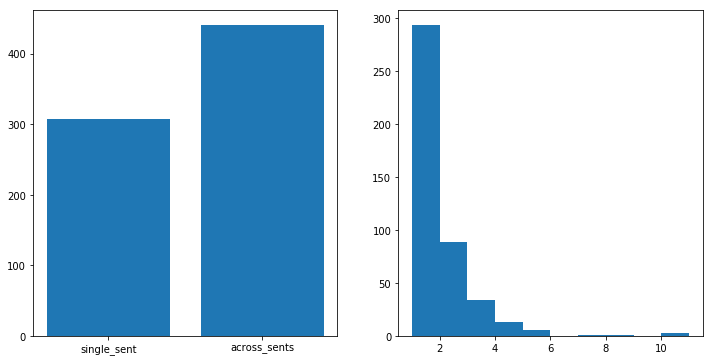

In [10]:
print("In single sent:", single_sent, ", across sents:", len(diff))
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

names = ['single_sent', 'across_sents']
values = [single_sent, len(diff)]
axs[0].bar(names, values)

axs[1].hist(diff)

plt.show()

# Generating negative training data

In [11]:
neg_candidates = sum(map(len, negative_pairs.values()))
len_posi = single_sent + len(diff)
negative_data = {}

neg_single_sent, neg_diff = 0, []

for doc, ent_pairs in negative_pairs.items():
    num_to_gen = round(len(ent_pairs) / neg_candidates * len_posi)
    # TODO: select from shortest distances
    picked_pairs = random.sample(ent_pairs, num_to_gen)
    
    neg_single_sent, neg_diff, negative_data = entity_pairs2data(picked_pairs,
                                                                 neg_single_sent,
                                                                 neg_diff,
                                                                 negative_data)

In [12]:
negative_data

{'doc_9': [("The patient has a 8 3/4-year-old daughter who has oxaluria of unknown etiology.The patient's mother had cysticercosis at 46 and also has Bone marrow cancer causing her to have her colon removed.",
   [2, 7],
   'OTHERS'),
  ("The patient has two brothers and two sisters in their 40’s-50's.Her 54-year-old sister has had some leukemia since her mid 30's.",
   [3, 4],
   'OTHERS'),
  ("The patient's mother had cysticercosis at 46 and also has Bone marrow cancer causing her to have her colon removed.Her 54-year-old sister has had some leukemia since her mid 30's.",
   [7, 4],
   'OTHERS'),
  ("The patient has a 8 3/4-year-old daughter who has oxaluria of unknown etiology.The patient's partner is 45 and healthy.",
   [2, 11],
   'OTHERS'),
  ('Her youngest daughter, age 39, has what sounds like germ cell tumour ovarian recurrent.One of her sons has a single, rather large connective tissue that sounds like it is several centimeters in diameter.',
   [17, 15],
   'OTHERS'),
  ("T

For negative data:
In single sent: 60 , across sents: 677


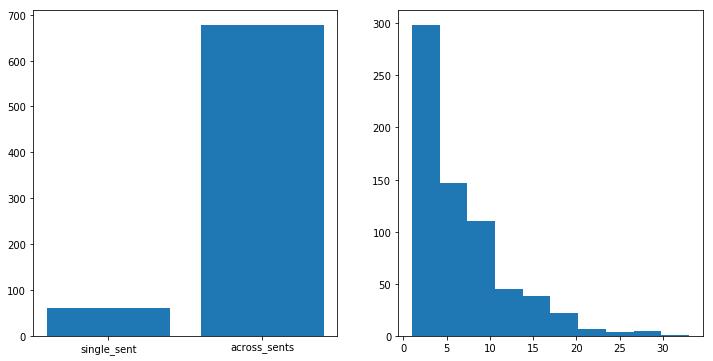

In [13]:
print("For negative data:\nIn single sent:", neg_single_sent, ", across sents:", len(neg_diff))
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

names = ['single_sent', 'across_sents']
values = [neg_single_sent, len(neg_diff)]
axs[0].bar(names, values)

axs[1].hist(neg_diff)

plt.show()